## Week 10 Homework

---

### Q1: perform Bayesian Logistic Regression 

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

### Q2: perform Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics



In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


            mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]   -0.86  0.11   -1.06    -0.66        0.0      0.0   2880.18   
betas[1]    0.22  0.12   -0.01     0.45        0.0      0.0   2664.47   
betas[2]    1.09  0.14    0.82     1.34        0.0      0.0   2915.41   
betas[3]   -0.26  0.12   -0.52    -0.05        0.0      0.0   3273.85   
betas[4]    0.05  0.12   -0.18     0.28        0.0      0.0   2999.83   
...          ...   ...     ...      ...        ...      ...       ...   
theta[609]  0.31  0.05    0.23     0.40        0.0      0.0   3027.36   
theta[610]  0.02  0.01    0.01     0.04        0.0      0.0   3066.97   
theta[611]  0.70  0.08    0.54     0.85        0.0      0.0   3149.57   
theta[612]  0.78  0.09    0.60     0.92        0.0      0.0   3063.58   
theta[613]  0.06  0.02    0.03     0.10        0.0      0.0   2982.06   

            ess_tail  r_hat  
betas[0]     1782.47    1.0  
betas[1]     1258.09    1.0  
betas[2]     1527.42    1.0  
bet

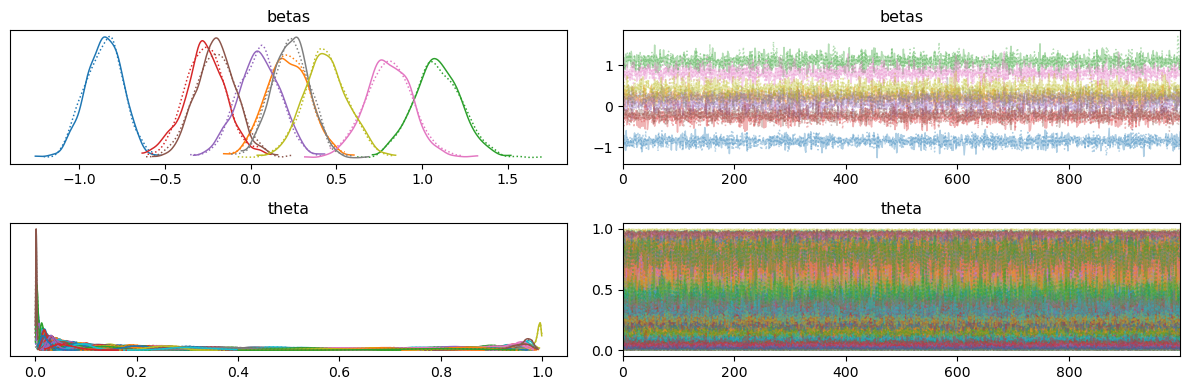

In [2]:
# Q1

# Load the Pima Indians Diabetes dataset from a GitHub mirror (kaggel:https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
column_names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
                "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
data = pd.read_csv(url, header=None, names=column_names)

# Separate predictors (X) and outcome (y)
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Standardize predictors for better convergence in MCMC
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
n_features = X_train.shape[1]


# Build the Bayesian logistic regression model using PyMC3
with pm.Model() as logistic_model:
    # Intercept with a normal prior
    betas = pm.Normal('betas', mu=0, sigma=1, shape=n_features)
    
    # Coefficients for predictors: using independent normals
    linear_combination = pm.math.dot(X_train, betas)
    
    # Likelihood: outcome is modeled as Bernoulli with logit link
    theta = pm.Deterministic('theta', pm.math.sigmoid(linear_combination))
    y_obs = pm.Bernoulli('y_obs', p=theta, observed=y_train)
    
    # Run MCMC sampling
    trace = pm.sample(1000, tune=1000, cores=2, random_seed=42)
    
# Display a summary of the posterior estimates and diagnostics (Rhat, effective sample sizes, etc.)
summary_df = az.summary(trace, round_to=2)
print(summary_df)

# Plot trace and posterior distributions for the parameters
az.plot_trace(trace)
plt.tight_layout()
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 228 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


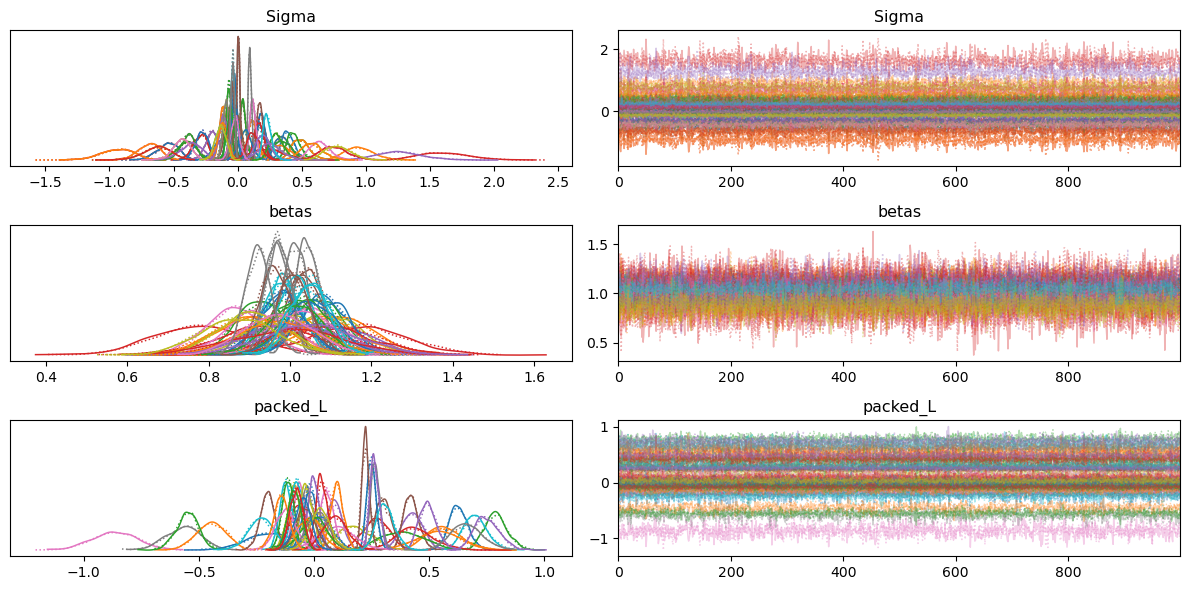

In [3]:
# Q2
# Load the dataset(https://www.kaggle.com/datasets/janiobachmann/math-students/data)
data = pd.read_csv('student_mat.csv')

# Select numerical columns only
numerical_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 
                  'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 
                  'health', 'absences', 'G1', 'G2', 'G3']
numerical_data = data[numerical_cols]

# Normalize the data
scaler = StandardScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(numerical_data), columns=numerical_cols)

# Select dataset configuration (n=100, p=5)
np.random.seed(42)  # For reproducibility
selected_predictors = np.random.choice(numerical_cols[:-3], 5, replace=False)  # Select 5 predictors, excluding G1, G2, G3
sampled_subset = normalized_data.sample(n=100, random_state=42)  # Select 100 samples

X_selected = sampled_subset[selected_predictors]
Y_selected = sampled_subset[['G1', 'G2', 'G3']]

X = X_selected.to_numpy()
Y = Y_selected.to_numpy()

# Define n, m, p
n, m, p = 100, 10, 5

# Generate synthetic data
beta_ = np.ones((p, m))
X = stats.norm().rvs((n, p))
a_cov = stats.invwishart(df=m+2, scale=np.eye(m)).rvs()
x = X @ beta_ + stats.multivariate_normal(mean=np.zeros(m), cov=a_cov).rvs(size=n)

# Bayesian Multivariate Regression Model
with pm.Model() as MNV_LKJ:
    # Define Cholesky decomposition of covariance matrix
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0, 
                                 sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    
    # Priors for regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))
    
    # Compute full covariance matrix
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    
    # Multivariate Normal likelihood
    y = pm.MvNormal('y', mu=X @ betas, chol=L, observed=x)
    
    # Perform MCMC sampling
    trace = pm.sample(1000, tune=1000, cores=2, random_seed=42)

# Summarize the posterior distributions
az.summary(trace)

# Plot trace diagnostics
az.plot_trace(trace)
plt.tight_layout()

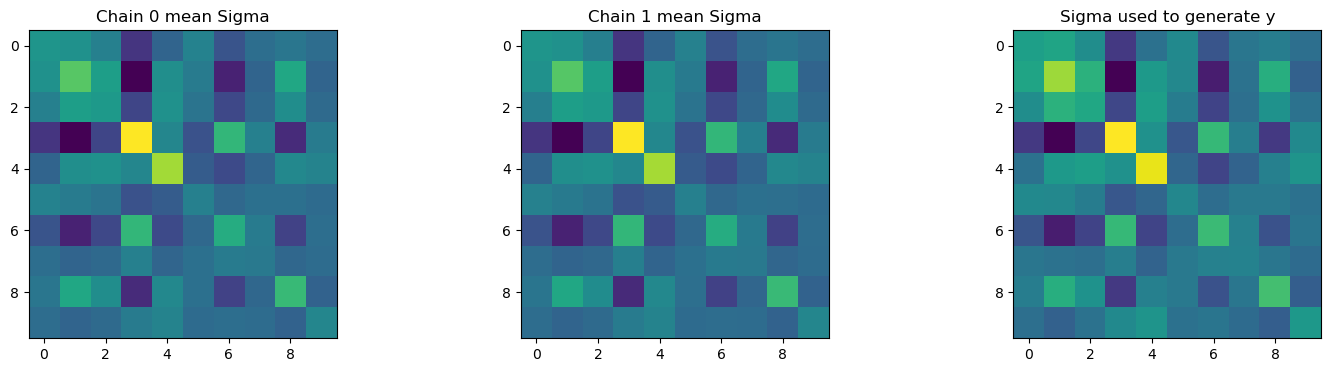

In [4]:
# Visualization of covariance matrices
num_chains = trace.posterior['Sigma'].shape[0] 
fig, ax = plt.subplots(1, num_chains + 1, figsize=(18, 4))
ax[-1].imshow(a_cov)
ax[-1].set_title("Sigma used to generate y")
for chain in range(num_chains):
    ax[chain].imshow(trace.posterior['Sigma'].mean(dim=['draw'])[chain])
    ax[chain].set_title(f"Chain {chain} mean Sigma")



### Probit Regression (as opposed to Logistic Regression)

- $\Phi$ is CDF of standard normal (and is also call the **inverse probit** function)
    - The **probit** function is $\Phi^{-1}$
- $z_i \sim N(x_i^\top\beta,1)$


$$\int \Phi(z_i)^{y_i} (1-\Phi(z_i))^{1-y_i}d\Phi(z) = \Phi(x_i^\top\beta)^{y_i} (1-\Phi(x_i^\top\beta))^{1-y_i} = p_i^{y_i} (1-p_i)^{1-y_i} $$

### Q3: perform Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


In [5]:
# Q3

# Load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'

columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 
           'DiabetesPedigreeFunction', 'Age', 'Outcome']

# Read the dataset
data = pd.read_csv(url, header=None, names=columns)

# Define feature variables (X) and outcome variable (y)
X = data.drop(columns=['Outcome']).values  # All features
y = data['Outcome'].values  # Binary outcome

# Standardize features for better MCMC convergence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert y to a matrix with shape (n, 1)
y = y.reshape(-1, 1)

# downsample the dataset to 100 samples for quicker inference
n_subset = 100
indices = np.random.choice(range(X.shape[0]), n_subset, replace=False)

X_subsampled = X_scaled[indices]
y_subsampled = y[indices]




Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, z]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


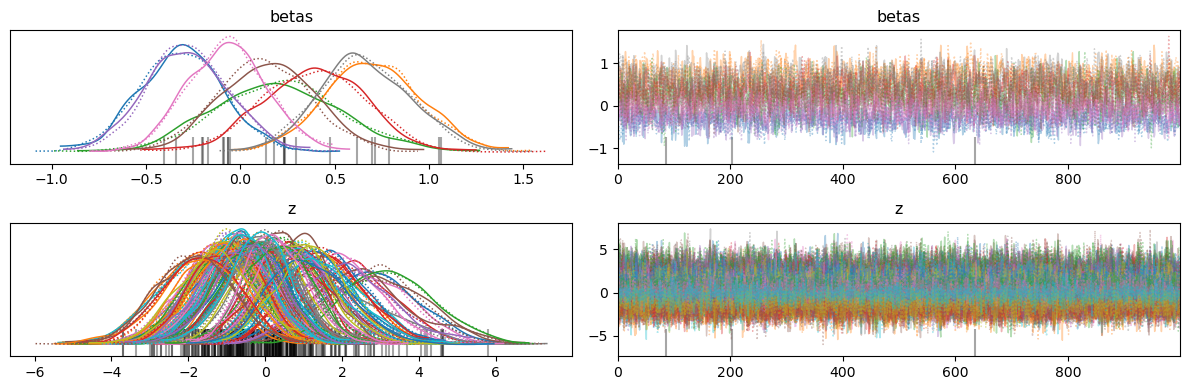

In [6]:
# Define the number of features (p) and outcomes (m)
n, p = X_subsampled.shape
m = 1  # Single binary outcome

# Build the Bayesian model with correct shape handling
with pm.Model() as model_fixed:
    # Priors for regression coefficients
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    
    # Latent variable with diagonal covariance instead of full correlation matrix
    z = pm.Normal("z", mu=pm.math.dot(X_subsampled, betas), sigma=1, shape=(n, m))
    
    # Observed binary outcome using inverse probit transformation
    y_obs = pm.Bernoulli("y", p=pm.math.invprobit(z), observed=y_subsampled)
    
    # MCMC Sampling (fewer iterations for efficiency)
    trace2 = pm.sample(1000, tune=1000, return_inferencedata=True,cores=2, random_seed=42)


# Summarize the posterior distributions
az.summary(trace2)

# Plot trace diagnostics
az.plot_trace(trace2)
plt.tight_layout()

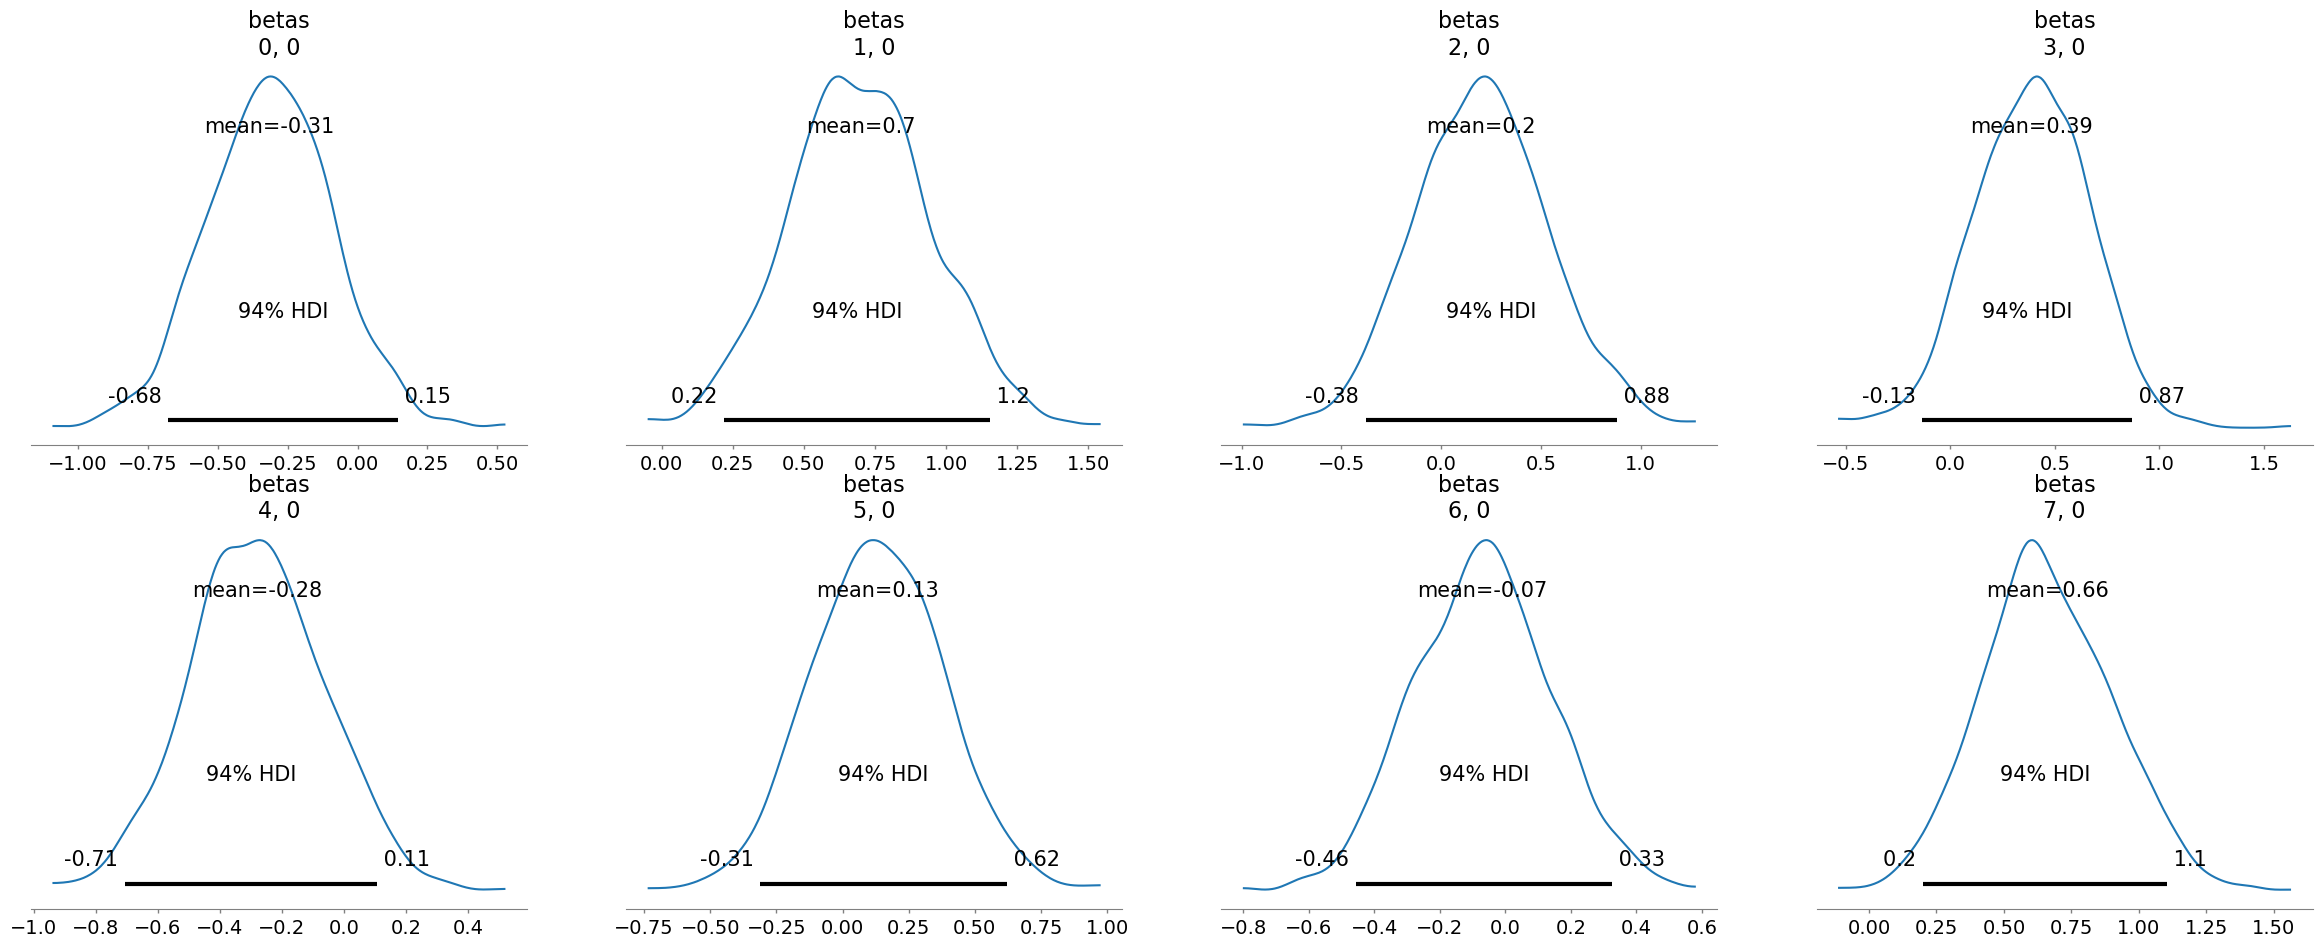

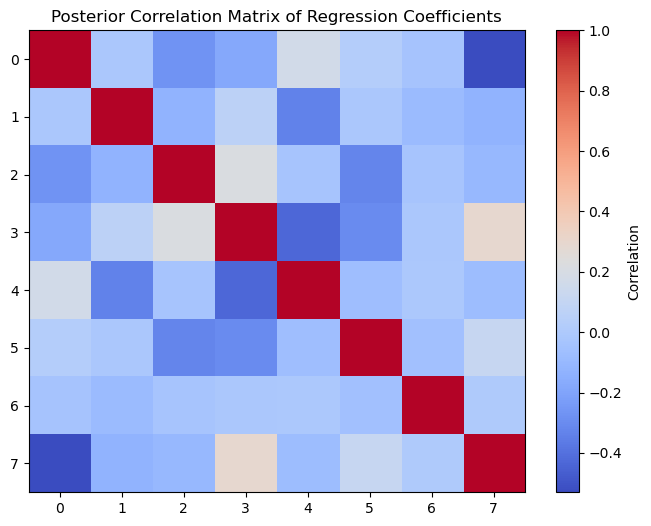

In [7]:
# Visualizing the posterior distributions of the regression coefficients
az.plot_posterior(trace2, var_names=["betas"])
plt.show()

# Extract posterior samples and reshape correctly
posterior_samples = trace2.posterior["betas"].stack(samples=("chain", "draw")).values

# Ensure it has the correct 2D shape (parameters × samples)
posterior_samples_reshaped = posterior_samples.reshape(p, -1)  

# Compute correlation matrix
cor_matrix = np.corrcoef(posterior_samples_reshaped)

# Plot correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(cor_matrix, cmap="coolwarm", interpolation="nearest", aspect="auto")
plt.colorbar(label="Correlation")
plt.title("Posterior Correlation Matrix of Regression Coefficients")
plt.show()



In [8]:
# Display posterior distribution summary
print(az.summary(trace2))

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0] -0.314  0.222  -0.677    0.146      0.007    0.004    1072.0   
betas[1, 0]  0.700  0.249   0.220    1.153      0.008    0.005    1054.0   
betas[2, 0]  0.200  0.335  -0.379    0.883      0.009    0.006    1278.0   
betas[3, 0]  0.388  0.274  -0.134    0.870      0.008    0.005    1225.0   
betas[4, 0] -0.281  0.218  -0.707    0.106      0.006    0.004    1272.0   
...            ...    ...     ...      ...        ...      ...       ...   
z[95, 0]    -1.808  1.000  -3.681    0.089      0.019    0.023    2815.0   
z[96, 0]     0.264  0.821  -1.220    1.796      0.013    0.021    3727.0   
z[97, 0]    -0.135  0.878  -1.864    1.424      0.015    0.021    3675.0   
z[98, 0]    -1.314  0.926  -3.095    0.346      0.017    0.021    3041.0   
z[99, 0]    -0.176  0.830  -1.861    1.250      0.014    0.020    3435.0   

             ess_tail  r_hat  
betas[0, 0]    1392.0    1.0  
betas[1, 0]    1411.0    